In [217]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import wandb
import pandas as pd

from scipy.stats import ttest_ind

In [218]:
api = wandb.Api()
api_runs = list(api.runs("ponderingparameters/model_part_sweeps"))

In [219]:
runs = {}
for run in tqdm(api_runs):
    # print(f"Run ID: {run.id}, Name: {run.name}")
    runs[run.id] = {}
    runs[run.id]["config"] = run.config
    runs[run.id]["summary"] = run.summary
    # runs[run.id]["history"] = run.history()
    runs[run.id]["name"] = run.name
# runs['6l22oxvg']['config']

100%|██████████| 128/128 [00:00<00:00, 67889.59it/s]


In [253]:
df = pd.read_csv("wandb_export_2024-03-27T12.csv")

df = df[['Name',
    'State',
    'Runtime',
    'no_time',
    'no_space',
    'no_given',
    'global_self_attn',
    'local_self_attn',
    'global_cross_attn',
    'local_cross_attn',
    'gpus',
    'train/forecast_loss',
    'val/forecast_loss',
    'test/forecast_loss',
    'train/norm_mse',
    'val/norm_mse',
    'test/norm_mse',]]

df.sort_values(by='train/forecast_loss', inplace=True)

# convert these colums to bools

for feature in ['global_self_attn', 'local_self_attn', 'global_cross_attn', 'local_cross_attn']:
    df[feature] = df[feature] == 'full'

# invert 'no_time','no_space','no_given'; confuses the fuck out of me. it's a double negative. True should represent the feature is present
df['time'] = ~df['no_time']
df['space'] = ~df['no_space']
df['given'] = ~df['no_given']
# drop double negative
df = df.drop(columns=['no_time',"no_space",'no_given'])


# there are half a dozen failed runs. I don't know why. Need to look into it.
# - one cause is when local/global is off in encoder but cross is on in decoder
fails = df[df['State']=='failed'].copy()
df = df[df['State']!='failed']
df = df.reset_index(drop=True)

In [259]:
fails[fails['space']==True]

,Name,State,Runtime,global_self_attn,local_self_attn,global_cross_attn,local_cross_attn,gpus,train/forecast_loss,val/forecast_loss,test/forecast_loss,train/norm_mse,val/norm_mse,test/norm_mse,time,space,given
2,peachy-sweep-126,failed,182,False,False,False,False,[1],NaN,NaN,NaN,NaN,NaN,NaN,False,True,False
14,leafy-sweep-114,failed,172,False,True,False,False,[2],NaN,NaN,NaN,NaN,NaN,NaN,False,True,True
70,misunderstood-sweep-57,failed,137,False,False,True,False,[2],NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
71,dainty-sweep-58,failed,138,False,False,True,False,[2],NaN,NaN,NaN,NaN,NaN,NaN,False,True,True
81,vibrant-sweep-45,failed,156,False,False,True,True,[1],NaN,NaN,NaN,NaN,NaN,NaN,True,True,False


In [260]:
def generate_mask(df, features=[]):
    # Define all possible features and their corresponding column in the dataframe
    feature_columns = ['time', 'space', 'given', 'global_self_attn', 'local_self_attn', 'global_cross_attn', 'local_cross_attn']

    # Start with a mask that selects all rows
    mask = np.array([True] * len(df))

    # Update the mask for each feature, excluding those specified
    for feature in feature_columns:
        if feature not in features:
            mask &= (df[feature] == False)
        else:
            mask &= (df[feature] == True)

    return mask


baseline_filter = generate_mask(df, features=[]) # all off
baseline_df = df[baseline_filter]

# Mean forecast losses for the baseline
baseline_means = baseline_df[['train/forecast_loss', 'val/forecast_loss', 'test/forecast_loss']].mean()

# Function to compare a feature's impact against the baseline
def compare_to_baseline(feature):
    feature_on_filter = generate_mask(df,features=[feature])
    feature_on_means = df[feature_on_filter][['train/forecast_loss', 'val/forecast_loss', 'test/forecast_loss']].mean()
    return feature_on_means

train_feature_impacts = {}
val_feature_impacts = {}
test_feature_impacts = {}
features = ['time', 'space', 'given', 'global_self_attn', 'local_self_attn', 'global_cross_attn', 'local_cross_attn']

for feature in features:
    tmp = compare_to_baseline(feature)
    # Calculating the difference in forecast losses between the baseline and the feature being analyzed
    train_feature_impacts[feature] = baseline_means['train/forecast_loss'] - tmp['train/forecast_loss']
    val_feature_impacts[feature] = baseline_means['val/forecast_loss'] - tmp['val/forecast_loss']
    test_feature_impacts[feature] = baseline_means['test/forecast_loss'] - tmp['test/forecast_loss']

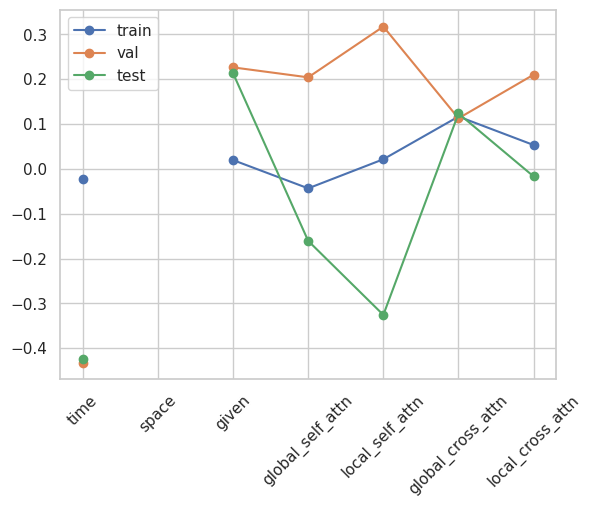

In [261]:
x = np.arange(len(train_feature_impacts.keys()))
plt.plot(x,train_feature_impacts.values(), label='train', marker='o')
plt.plot(x,val_feature_impacts.values(), label='val', marker='o')
plt.plot(x,test_feature_impacts.values(), label='test', marker='o')
plt.xticks(x, val_feature_impacts.keys(), rotation=45);
plt.legend()

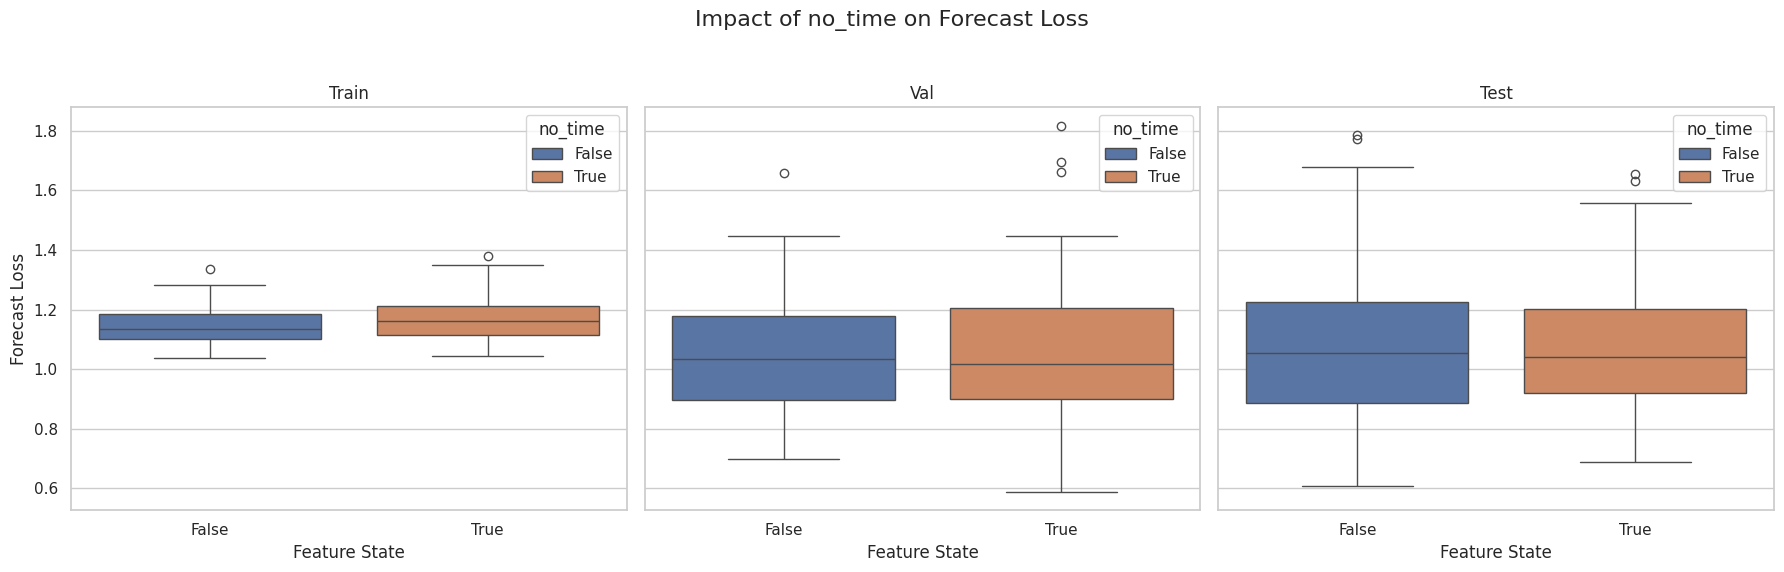

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Function to create box plots for a feature across forecast loss types
def create_box_plots(feature):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle(f'Impact of {feature} on Forecast Loss', fontsize=16)

    loss_types = ['train/forecast_loss', 'val/forecast_loss', 'test/forecast_loss']
    for ax, loss_type in zip(axes.flat, loss_types):
        sns.boxplot(x=feature, y=loss_type, df=df, ax=ax, hue=feature)
        ax.set_title(loss_type.split('/')[0].capitalize())
        ax.set_xlabel('Feature State')
        ax.set_ylabel('Forecast Loss')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Example visualization for 'no_time'
create_box_plots('no_time')
